14:47:06 - cmdstanpy - INFO - Chain [1] start processing
14:47:06 - cmdstanpy - INFO - Chain [1] done processing


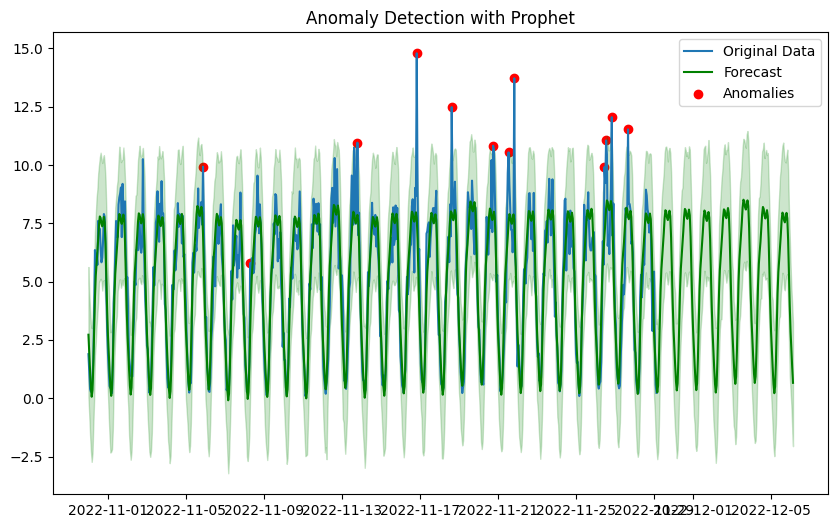

In [5]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

class TimeSeriesAnomalyDetector:
    def __init__(self, uncertainty_interval=0.95):
        """
        Initialize the anomaly detector.
        
        :param uncertainty_interval: Confidence interval for uncertainty in forecasting (default is 95%)
        """
        self.uncertainty_interval = uncertainty_interval
        self.model = Prophet(interval_width=self.uncertainty_interval)
    
    def prepare_time_series_data(self,file_path):
        """
        Prepare the CSV file for anomaly detection by selecting the 'time' column as 'ds' 
        and the 'userDlAvrgThroughputKbps' column as 'y'.
        
        :param file_path: Path to the CSV file
        :return: DataFrame with 'ds' (time) and 'y' (target variable)
        """
        # Read the CSV
        df = pd.read_csv(file_path)
        
        # Select the relevant columns
        df_prepared = df[['tiempo', 'TRAFFIC_D_USER_DL_GB']].copy()
        
        # Rename columns for Prophet compatibility
        df_prepared.rename(columns={'tiempo': 'ds', 'TRAFFIC_D_USER_DL_GB': 'y'}, inplace=True)
        df_prepared = df_prepared.groupby('ds').sum().reset_index()
        
        # Convert 'ds' to datetime
        df_prepared['ds'] = pd.to_datetime(df_prepared['ds'])
    
        return df_prepared

    def read_time_series(self, file_path):
        """
        Read a time series CSV file with 'ds' as date and 'y' as the target variable.
        
        :param file_path: Path to the CSV file
        :return: DataFrame with the time series data
        """
        df = self.prepare_time_series_data(file_path)
        return df
    
    def create_forecast(self, df, periods=168, freq='h'):
        """
        Create a forecast using Prophet with one point per hour and a 7-day forecast (168 hours).
        
        :param df: DataFrame with time series data
        :param periods: Number of forecast points (168 points = 7 days hourly forecast)
        :param freq: Frequency of the time series ('h' for hourly)
        :return: DataFrame with forecast and confidence intervals
        """
        # Fit the model
        self.model.fit(df) #Longest Step

        # Create a DataFrame for future dates
        future = self.model.make_future_dataframe(periods=periods, freq=freq)
        self.future = future
        # Generate forecast
        forecast = self.model.predict(future)
        return forecast

    def detect_anomalies(self, df, forecast):
        """
        Detect anomalies where actual data points are outside the forecasted confidence interval.
        
        :param df: Original time series DataFrame
        :param forecast: Forecast DataFrame with confidence intervals
        :return: DataFrame with anomaly flag
        """
        # Merge the original data with forecast
        merged = pd.merge(df, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='right')

        # Create anomaly flag
        merged['anomaly'] = 0
        merged.loc[(merged['y'] < merged['yhat_lower']) | (merged['y'] > merged['yhat_upper']), 'anomaly'] = 1
        
        return merged
    
    def plot_anomalies(self, df_with_anomalies):
        """
        Plot the original time series, forecasted values, and highlight the anomalies.
        
        :param df_with_anomalies: DataFrame with anomalies flagged
        """
        plt.figure(figsize=(10, 6))

        # Plot original values
        plt.plot(df_with_anomalies['ds'], df_with_anomalies['y'], label='Original Data')

        # Plot forecast
        plt.plot(df_with_anomalies['ds'], df_with_anomalies['yhat'], label='Forecast', color='green')

        # Plot anomalies
        anomalies = df_with_anomalies[df_with_anomalies['anomaly'] == 1]
        plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies', marker='o')

        plt.fill_between(df_with_anomalies['ds'], df_with_anomalies['yhat_lower'], df_with_anomalies['yhat_upper'], color='green', alpha=0.2)
        plt.title('Anomaly Detection with Prophet')
        plt.legend()
        plt.show()




if __name__ == "__main__":
    # Initialize the detector
    detector = TimeSeriesAnomalyDetector(uncertainty_interval=0.99)

    # Load time series data from a CSV
    # The CSV should have two columns: 'ds' (dates) and 'y' (values)
    # Replace with DB Query
    time_series_file = 'df_short.csv'
    df = detector.read_time_series(time_series_file)

    # Create forecast
    forecast_df = detector.create_forecast(df, periods=168, freq='h')

    # Detect anomalies
    df_with_anomalies = detector.detect_anomalies(df, forecast_df)

    # Plot anomalies
    detector.plot_anomalies(df_with_anomalies)

    # Save the forecast to a CSV file (optional)
    df_with_anomalies.to_csv('forecast_with_anomalies.csv', index=False)


In [6]:
detector.future

,ds
0,2022-10-31 00:00:00
1,2022-10-31 01:00:00
2,2022-10-31 02:00:00
3,2022-10-31 03:00:00
4,2022-10-31 04:00:00
...,...
863,2022-12-05 23:00:00
864,2022-12-06 00:00:00
865,2022-12-06 01:00:00
866,2022-12-06 02:00:00
